In [1]:
from __future__ import division
import numpy as np
from graphviz import Source
from qnetwork import *
from utils import *
import matplotlib.pyplot as plt
from env_sensing_error_small import *
# from Plot_Path import *
import tensorflow as tf
import sys
from dra_planning import *
from full_prod_DRA import *

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def train(sess, env, qnet):
    
    global EXPLORATION_RATE
  
    summary_ops, summary_vars = build_summaries()

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(SUMMARY_DIR, sess.graph)
    
    qnet.update_target()
    
    replay_buffer = ReplayBuffer(BUFFER_SIZE, RANDOM_SEED)
    
    for num_epi in range(MAX_EPISODES):

        s = env.reset()
        s = [list(np.unravel_index(s, env.shape))]

        ep_reward = 0
        ep_ave_max_q = 0
        
        reward_list = []

        for j in range(MAX_EPISODE_LEN):

            a = np.argmax(qnet.predict_q(np.reshape(s, (1, qnet.state_dim))))
    
            if np.random.rand(1) < EXPLORATION_RATE:
                s2, r, terminal, info = env.step(np.random.randint(0,qnet.action_dim))
            else:
                s2, r, terminal, info = env.step(a)
            
            s2 = list(np.unravel_index(s2, env.shape))

            replay_buffer.add(np.reshape(s, (qnet.state_dim,)), np.reshape(a, (1,)), r,
                              terminal, np.reshape(s2, (qnet.state_dim,)))

            # Keep adding experience to the memory until
            # there are at least minibatch size samples
            if replay_buffer.size() > MINIBATCH_SIZE:
                s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(MINIBATCH_SIZE)

                # Calculate targets
                target_q = qnet.predect_target(s2_batch)

                y_i = []
                for k in range(MINIBATCH_SIZE):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + GAMMA * np.amax(target_q[k]))

                # Update the critic given the targets
                predicted_q_value, _ = qnet.train(s_batch, a_batch, np.reshape(y_i, (MINIBATCH_SIZE, 1)), num_epi)

                ep_ave_max_q += np.amax(predicted_q_value)
                
                # Update target networks
                qnet.update_target()

            s = s2
            ep_reward += r

            if terminal or j == MAX_EPISODE_LEN-1:
                
                if EXPLORATION_RATE > 0.02 and terminal:
                    EXPLORATION_RATE = EXPLORATION_RATE*0.98
                    
                reward_list += [ep_reward]
                
                if np.average(reward_list[-10:]) > LR_DECAY_TRUNCATION:
                    qnet.decay_learning_rate(0.98)

                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: ep_reward,
                    summary_vars[1]: ep_ave_max_q / float(j),
                    summary_vars[2]: EXPLORATION_RATE,
                    summary_vars[3]: qnet.get_learning_rate()                    
                })

                writer.add_summary(summary_str, num_epi)
                writer.flush()

                print('| Reward: {:d} | Episode: {:d} | Qmax: {:.4f} | Exploration: {:.6f} | Step: {:d} '.format(int(ep_reward), \
                        num_epi, (ep_ave_max_q / float(j)), EXPLORATION_RATE, j))
                
                f = open("stats.txt", "ab")
                f.write("| Reward: " + str(int(ep_reward)) 
                        +" | Episode: " + str(num_epi) 
                        + " | Qmax: " + str(ep_ave_max_q / float(j)) 
                        + " | Exploration: " + str(EXPLORATION_RATE) + "\n")
                f.close()
                
                f = open(SUMMARY_DIR + "/reward.txt", "ab") 
                f.write(str(int(ep_reward)))
                f.close()
                
                break
                
        if num_epi%10 == 0:
            state_list = []
            action_list = []
            world = np.zeros(env.shape)
            for state in range(env.nS):
                state = np.unravel_index(state, env.shape)
                action = qnet.predict_q(np.reshape(state, (1,state_dim)))
                action = np.argmax(action)
                state_list.append(state)
                action_list.append(action)
                
#             print np.reshape(action_list, env.shape)
                
            f = open("action.txt","ab")
            act_string = np.array_str(np.reshape(action_list, env.shape))
            f.write(act_string)
            f.write("---------------------------\n")
            f.close()
    
    

In [3]:
LEARNING_RATE = 0.0015
GAMMA = 0.99
# GAMMA = 0.7
TAU = 0.001
BUFFER_SIZE = 10**6
MINIBATCH_SIZE = 64
RANDOM_SEED = 210
MAX_EPISODES = 50000
MAX_EPISODE_LEN = 200
file_appendix = time.ctime()[4:16].replace("  ","").replace(" ","_").replace(":","-")
SUMMARY_DIR = './results/tf_ddqn_' + file_appendix
SAVE_DIR = "./saved_model/" + file_appendix + "/ddqn.ckpt"
EXPLORATION_RATE = 0.7
LR_DECAY_TRUNCATION = -200
RESTORE = 0
if sys.platform == "darwin":
    DEVICE = "/device:CPU:0"
else:
    DEVICE = "/device:GPU:0"

# LTL = "<>(A && <>(B && <> T)) && []<>A && []<>B"
# LTL = "[] (p1 -> !(X p1) U (p2 || p3) ) && []<>p1"
# LTL = "T && []<>A && []<>B"
# LTL = "<>(A && <>(B && <> T)) && []<>A && []<>B && []!C && []!D"
# LTL = "<>(A && <>(B && <> T)) && []<>A && []<>B && []!C"
# LTL = "<>(A && <>(B && <> T))"
# LTL = "<>(A && <>B) && <>[]T && []!C"
LTL = "<>(A && <>T) && []!C"
# LTL = "<>(A && <>(B && <>T)) && []<>(A||T) && []<>B && []!C"

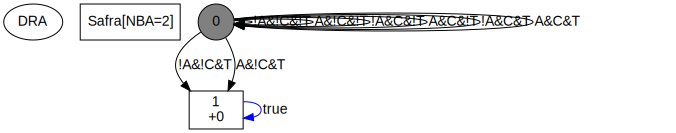

In [4]:
env = CurrentWorld(LTL)
with open("my.dot", "r") as dotfile:
    text = dotfile.read()
Source(text)

In [5]:
config=tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
       
    state_dim = 3
    action_dim = 5
    
    if RESTORE:
        Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR, DEVICE)
        Qnet.saver.restore(sess, RESTORE_PATH)
        train(sess, env, Qnet)
        
    else:
        np.random.seed(RANDOM_SEED)
        tf.set_random_seed(RANDOM_SEED)
        env.seed(RANDOM_SEED)
    
        Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR, DEVICE)

        train(sess, env, Qnet)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


DDQN Saved
| Reward: -2500 | Episode: 0 | Qmax: 1.4805 | Exploration: 0.686000 | Step: 116 
| Reward: -2540 | Episode: 1 | Qmax: 6.8732 | Exploration: 0.686000 | Step: 199 
| Reward: -2720 | Episode: 2 | Qmax: 0.0476 | Exploration: 0.686000 | Step: 199 
| Reward: -2810 | Episode: 3 | Qmax: 1.5818 | Exploration: 0.686000 | Step: 199 
| Reward: -2720 | Episode: 4 | Qmax: -1.0546 | Exploration: 0.686000 | Step: 199 
| Reward: -2900 | Episode: 5 | Qmax: -2.2787 | Exploration: 0.686000 | Step: 199 
| Reward: -3440 | Episode: 6 | Qmax: -5.4519 | Exploration: 0.686000 | Step: 199 
| Reward: -2450 | Episode: 7 | Qmax: -7.4676 | Exploration: 0.686000 | Step: 199 
| Reward: -1480 | Episode: 8 | Qmax: -9.7153 | Exploration: 0.672280 | Step: 122 
| Reward: -2630 | Episode: 9 | Qmax: -11.1628 | Exploration: 0.672280 | Step: 199 
| Reward: -2090 | Episode: 10 | Qmax: -11.8967 | Exploration: 0.658834 | Step: 174 
| Reward: -2180 | Episode: 11 | Qmax: -8.7525 | Exploration: 0.658834 | Step: 199 
| Rew

| Reward: -2230 | Episode: 98 | Qmax: -105.6024 | Exploration: 0.527549 | Step: 179 
| Reward: -410 | Episode: 99 | Qmax: -120.7500 | Exploration: 0.516998 | Step: 33 
DDQN Saved
| Reward: -1280 | Episode: 100 | Qmax: -105.2850 | Exploration: 0.506658 | Step: 138 
| Reward: -2180 | Episode: 101 | Qmax: -102.3807 | Exploration: 0.506658 | Step: 199 
| Reward: -2090 | Episode: 102 | Qmax: -108.9529 | Exploration: 0.506658 | Step: 199 
| Reward: -2450 | Episode: 103 | Qmax: -105.7498 | Exploration: 0.506658 | Step: 199 
| Reward: -1470 | Episode: 104 | Qmax: -100.8588 | Exploration: 0.496525 | Step: 121 
| Reward: -2450 | Episode: 105 | Qmax: -102.4370 | Exploration: 0.496525 | Step: 199 
| Reward: -2360 | Episode: 106 | Qmax: -111.0719 | Exploration: 0.496525 | Step: 199 
| Reward: -2360 | Episode: 107 | Qmax: -109.0323 | Exploration: 0.496525 | Step: 199 
| Reward: -1370 | Episode: 108 | Qmax: -110.7263 | Exploration: 0.486595 | Step: 147 
| Reward: -1030 | Episode: 109 | Qmax: -112.885

| Reward: -1720 | Episode: 195 | Qmax: -64.6000 | Exploration: 0.180819 | Step: 182 
| Reward: -1640 | Episode: 196 | Qmax: -47.1878 | Exploration: 0.177203 | Step: 165 
| Reward: -580 | Episode: 197 | Qmax: -40.1250 | Exploration: 0.173659 | Step: 68 
| Reward: -620 | Episode: 198 | Qmax: -57.8943 | Exploration: 0.170186 | Step: 72 
| Reward: -1940 | Episode: 199 | Qmax: -48.8633 | Exploration: 0.166782 | Step: 186 
DDQN Saved
| Reward: -1590 | Episode: 200 | Qmax: -50.6141 | Exploration: 0.163446 | Step: 160 
| Reward: -1690 | Episode: 201 | Qmax: -44.1320 | Exploration: 0.160178 | Step: 179 
| Reward: -380 | Episode: 202 | Qmax: -63.5126 | Exploration: 0.156974 | Step: 39 
| Reward: -770 | Episode: 203 | Qmax: -23.5800 | Exploration: 0.153834 | Step: 69 
| Reward: -2000 | Episode: 204 | Qmax: -49.1378 | Exploration: 0.153834 | Step: 199 
| Reward: -2000 | Episode: 205 | Qmax: -55.9180 | Exploration: 0.153834 | Step: 199 
| Reward: -100 | Episode: 206 | Qmax: -50.8581 | Exploration: 

| Reward: -70 | Episode: 295 | Qmax: 0.3521 | Exploration: 0.027623 | Step: 8 
| Reward: -90 | Episode: 296 | Qmax: -29.3832 | Exploration: 0.027070 | Step: 10 
| Reward: -70 | Episode: 297 | Qmax: -32.9615 | Exploration: 0.026529 | Step: 8 
| Reward: -70 | Episode: 298 | Qmax: 35.7983 | Exploration: 0.025999 | Step: 8 
| Reward: -70 | Episode: 299 | Qmax: 73.8880 | Exploration: 0.025479 | Step: 8 
DDQN Saved
| Reward: -110 | Episode: 300 | Qmax: 59.9068 | Exploration: 0.024969 | Step: 12 
| Reward: -220 | Episode: 301 | Qmax: 38.5160 | Exploration: 0.024470 | Step: 23 
| Reward: -70 | Episode: 302 | Qmax: 34.5687 | Exploration: 0.023980 | Step: 8 
| Reward: -70 | Episode: 303 | Qmax: 37.7447 | Exploration: 0.023501 | Step: 8 
| Reward: -70 | Episode: 304 | Qmax: 25.8776 | Exploration: 0.023031 | Step: 8 
| Reward: -70 | Episode: 305 | Qmax: -0.2474 | Exploration: 0.022570 | Step: 8 
| Reward: -70 | Episode: 306 | Qmax: -6.8916 | Exploration: 0.022119 | Step: 8 
| Reward: -70 | Episode

| Reward: -90 | Episode: 397 | Qmax: 79.6298 | Exploration: 0.019993 | Step: 10 
| Reward: -80 | Episode: 398 | Qmax: 35.9589 | Exploration: 0.019993 | Step: 9 
| Reward: -70 | Episode: 399 | Qmax: 11.2225 | Exploration: 0.019993 | Step: 8 
DDQN Saved
| Reward: -70 | Episode: 400 | Qmax: 68.7092 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 401 | Qmax: 45.6989 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 402 | Qmax: 72.2492 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 403 | Qmax: 7.6878 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 404 | Qmax: 39.9351 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 405 | Qmax: 92.4657 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 406 | Qmax: 67.8223 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 407 | Qmax: 80.2934 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 408 | Qmax: 85.6167 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 409 

| Reward: -70 | Episode: 499 | Qmax: 115.6860 | Exploration: 0.019993 | Step: 8 
DDQN Saved
| Reward: -70 | Episode: 500 | Qmax: 95.1718 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 501 | Qmax: 52.0948 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 502 | Qmax: 72.2085 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 503 | Qmax: 49.6510 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 504 | Qmax: 84.2523 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 505 | Qmax: 108.2662 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 506 | Qmax: 71.6894 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 507 | Qmax: 55.7170 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 508 | Qmax: 73.9362 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 509 | Qmax: 89.3518 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 510 | Qmax: 93.2718 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode:

| Reward: -70 | Episode: 601 | Qmax: 88.1472 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 602 | Qmax: 51.2806 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 603 | Qmax: 103.3985 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 604 | Qmax: 57.3197 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 605 | Qmax: 93.3713 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 606 | Qmax: 81.0321 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 607 | Qmax: 68.9935 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 608 | Qmax: 107.8362 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 609 | Qmax: 114.1338 | Exploration: 0.019993 | Step: 10 
| Reward: -80 | Episode: 610 | Qmax: 107.8261 | Exploration: 0.019993 | Step: 9 
| Reward: -70 | Episode: 611 | Qmax: 89.5535 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 612 | Qmax: 93.0070 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 613 | Qmax

| Reward: -70 | Episode: 702 | Qmax: 109.1648 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 703 | Qmax: 84.4839 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 704 | Qmax: 95.8909 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 705 | Qmax: 118.0004 | Exploration: 0.019993 | Step: 8 
| Reward: -160 | Episode: 706 | Qmax: 106.0781 | Exploration: 0.019993 | Step: 17 
| Reward: -70 | Episode: 707 | Qmax: 77.2343 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 708 | Qmax: 110.3676 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 709 | Qmax: 104.3940 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 710 | Qmax: 110.6616 | Exploration: 0.019993 | Step: 8 
| Reward: -150 | Episode: 711 | Qmax: 100.4249 | Exploration: 0.019993 | Step: 16 
| Reward: -70 | Episode: 712 | Qmax: 92.5312 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 713 | Qmax: 86.6885 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 714 

| Reward: -70 | Episode: 803 | Qmax: 106.1389 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 804 | Qmax: 122.8902 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 805 | Qmax: 93.2855 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 806 | Qmax: 108.8379 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 807 | Qmax: 95.5603 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 808 | Qmax: 109.8500 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 809 | Qmax: 98.1613 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 810 | Qmax: 108.1751 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 811 | Qmax: 91.5357 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 812 | Qmax: 124.0715 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 813 | Qmax: 76.8736 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 814 | Qmax: 115.3404 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 815 | 

| Reward: -70 | Episode: 904 | Qmax: 105.0572 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 905 | Qmax: 119.0085 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 906 | Qmax: 109.2878 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 907 | Qmax: 119.7876 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 908 | Qmax: 117.8169 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 909 | Qmax: 81.0831 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 910 | Qmax: 105.4495 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 911 | Qmax: 105.6949 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 912 | Qmax: 113.1999 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 913 | Qmax: 104.4914 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 914 | Qmax: 101.1401 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 915 | Qmax: 109.3019 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 916 

| Reward: -70 | Episode: 1005 | Qmax: 114.3510 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1006 | Qmax: 103.4401 | Exploration: 0.019993 | Step: 8 
| Reward: -80 | Episode: 1007 | Qmax: 114.5819 | Exploration: 0.019993 | Step: 9 
| Reward: -70 | Episode: 1008 | Qmax: 112.2486 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1009 | Qmax: 111.5760 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1010 | Qmax: 112.9781 | Exploration: 0.019993 | Step: 8 
| Reward: -180 | Episode: 1011 | Qmax: 118.5551 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 1012 | Qmax: 96.2146 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1013 | Qmax: 107.1909 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1014 | Qmax: 108.1224 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1015 | Qmax: 115.3500 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1016 | Qmax: 108.7125 | Exploration: 0.019993 | Step: 8 
| Reward: -90 |

| Reward: -70 | Episode: 1105 | Qmax: 111.8600 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1106 | Qmax: 101.8245 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1107 | Qmax: 103.5347 | Exploration: 0.019993 | Step: 8 
| Reward: -110 | Episode: 1108 | Qmax: 110.5406 | Exploration: 0.019993 | Step: 12 
| Reward: -70 | Episode: 1109 | Qmax: 124.5128 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1110 | Qmax: 128.0800 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1111 | Qmax: 124.8319 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1112 | Qmax: 111.7817 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1113 | Qmax: 128.9061 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1114 | Qmax: 108.4951 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1115 | Qmax: 118.3287 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1116 | Qmax: 115.9125 | Exploration: 0.019993 | Step: 8 
| Reward: -70 

| Reward: -70 | Episode: 1204 | Qmax: 120.1567 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 1205 | Qmax: 114.5995 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 1206 | Qmax: 114.5894 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1207 | Qmax: 110.8586 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1208 | Qmax: 119.4236 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 1209 | Qmax: 105.8141 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 1210 | Qmax: 113.6684 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1211 | Qmax: 108.7639 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1212 | Qmax: 115.9806 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 1213 | Qmax: 88.3280 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 1214 | Qmax: 114.7789 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1215 | Qmax: 103.5276 | Exploration: 0.019993 | Step: 8 
| Reward: -70 

| Reward: -90 | Episode: 1304 | Qmax: 117.7615 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1305 | Qmax: 107.1476 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1306 | Qmax: 109.4002 | Exploration: 0.019993 | Step: 10 
| Reward: -20 | Episode: 1307 | Qmax: 109.5962 | Exploration: 0.019993 | Step: 12 
| Reward: -70 | Episode: 1308 | Qmax: 110.1606 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1309 | Qmax: 113.0361 | Exploration: 0.019993 | Step: 8 
| Reward: -90 | Episode: 1310 | Qmax: 100.6298 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 1311 | Qmax: 109.7529 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1312 | Qmax: 115.6089 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1313 | Qmax: 114.6890 | Exploration: 0.019993 | Step: 8 
| Reward: -180 | Episode: 1314 | Qmax: 105.3653 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 1315 | Qmax: 116.3139 | Exploration: 0.019993 | Step: 8 
| Reward: -70

| Reward: 0 | Episode: 1404 | Qmax: 109.9907 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1405 | Qmax: 110.0704 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1406 | Qmax: 125.0736 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1407 | Qmax: 114.6444 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1408 | Qmax: 108.3395 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1409 | Qmax: 115.8832 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1410 | Qmax: 105.0962 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1411 | Qmax: 110.6167 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1412 | Qmax: 107.2128 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1413 | Qmax: 118.5830 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1414 | Qmax: 115.9725 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1415 | Qmax: 120.9488 | Exploration: 0.019993 | Step: 10 
| Reward: -10 | Episode: 141

| Reward: 0 | Episode: 1504 | Qmax: 112.8118 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1505 | Qmax: 113.5842 | Exploration: 0.019993 | Step: 10 
| Reward: -20 | Episode: 1506 | Qmax: 98.0298 | Exploration: 0.019993 | Step: 12 
| Reward: -10 | Episode: 1507 | Qmax: 114.3578 | Exploration: 0.019993 | Step: 11 
| Reward: 0 | Episode: 1508 | Qmax: 106.3711 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1509 | Qmax: 113.8986 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1510 | Qmax: 106.0812 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1511 | Qmax: 111.7235 | Exploration: 0.019993 | Step: 10 
| Reward: -70 | Episode: 1512 | Qmax: 113.2483 | Exploration: 0.019993 | Step: 8 
| Reward: -170 | Episode: 1513 | Qmax: 113.1366 | Exploration: 0.019993 | Step: 9 
| Reward: -70 | Episode: 1514 | Qmax: 116.1887 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Episode: 1515 | Qmax: 110.4154 | Exploration: 0.019993 | Step: 8 
| Reward: -70 | Epis

| Reward: 0 | Episode: 1605 | Qmax: 112.7617 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1606 | Qmax: 113.7121 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1607 | Qmax: 113.6037 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1608 | Qmax: 101.3825 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1609 | Qmax: 111.2286 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1610 | Qmax: 111.4104 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1611 | Qmax: 111.5500 | Exploration: 0.019993 | Step: 10 
| Reward: -10 | Episode: 1612 | Qmax: 113.8309 | Exploration: 0.019993 | Step: 11 
| Reward: -10 | Episode: 1613 | Qmax: 115.9452 | Exploration: 0.019993 | Step: 11 
| Reward: 0 | Episode: 1614 | Qmax: 116.3157 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1615 | Qmax: 114.8058 | Exploration: 0.019993 | Step: 10 
| Reward: 0 | Episode: 1616 | Qmax: 118.6648 | Exploration: 0.019993 | Step: 10 
| Reward: -20 | Episode:

KeyboardInterrupt: 

In [ ]:
tf.reset_default_graph()

In [ ]:
plot_path(env, LTL, "./saved_model/Mar_29_07-25_OR/ddqn.ckpt", LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)

In [ ]:
plt.close("all")

In [ ]:
Opt_Policy = {}
restore_path = "./saved_model/Mar_17_04-08_10by10_dynamic_normal/ddqn.ckpt"

with tf.Session() as sess:
    
#     np.random.seed(RANDOM_SEED)
#     tf.set_random_seed(RANDOM_SEED)
#     env.seed(RANDOM_SEED)
    
    state_dim = 3
    action_dim = env.nA
    
    Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)
    saver = tf.train.Saver()
    saver.restore(sess, restore_path)
    
    for state in range(env.nS):
        state_for_nn = np.array(np.unravel_index(state, env.shape)).reshape(1, state_dim)
        action = Qnet.predict_a_from_save(state_for_nn, restore_path)
        Opt_Policy[state] = action[0]
    
    

In [ ]:
action_dict = {0: u"\u2191", 1: u"\u2192", 2: u"\u2193", 3: u"\u2190", 4: u"\u2613"}
worlds = [np.zeros((env.shape[0], env.shape[1])) for i in range(env.shape[2])]
color_dict = {ap: color+1 for color, ap in enumerate(env.ap_dict.keys())}

for world in worlds:
    world[env.start_state[:-1]] = len(env.ap_dict) + 1
    for i in env.coord_dict.keys():
        if len(env.coord_dict[i]) >=1:
            world[i] = color_dict[env.coord_dict[i][0]]
            
fig, ax = plt.subplots(2, int(np.ceil(len(worlds)/2)) )

for i in range(len(worlds)):
    index = np.unravel_index(i, (2, int( np.ceil(len(worlds)/2)) ) )
    ax[index[0]][index[1]].imshow(worlds[i])
    
for k in range(len(worlds)):
    index = np.unravel_index(k, (2, int(np.ceil(len(worlds)/2))))
    for i in env.ap_dict.keys():
        for j in env.ap_dict[i]:
            ax[index[0]][index[1]].annotate(i, xy=(j[1] - 0.13, j[0] + 0.13), fontsize=5, color=(0,0,0))

for i in range(len(worlds)):
    index = np.unravel_index(i, (2, int(np.ceil(len(worlds)/2))))
    ax[index[0]][index[1]].set_title("Rabin State = " + str(i))
    ax[index[0]][index[1]].annotate("R", xy=(env.start_state[1] - 0.13, env.start_state[0] + 0.13), fontsize=5, color=(1,0,0))
    for state, action in Opt_Policy.items():
        state = np.unravel_index(state, env.shape)
        if state[-1] == i:
            ax[index[0]][index[1]].annotate(action_dict[action], xy=(state[1]-0.13, state[0]+0.13), fontsize=10, color=(1,1,1))

In [ ]:
# Test how many times LTL are violated in 100 runs -- Static Environment

saved_path = "./saved_model/Mar_16_21-59_10by10_indefinitely_run/ddqn.ckpt"

state_dim = 3
action_dim = env.nA

counter = 0

c_coords = [np.ravel_multi_index(i, env.shape[:-1]) for i in env.ap_dict["C"]]

with tf.Session() as sess:
    Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)
    saver = tf.train.Saver()
    saver.restore(sess, saved_path)
    
    for num_i in range(100):
    
        state = env.reset()
        done = False

        for t in count():
            state_1d = state
            state = np.reshape(list(np.unravel_index(state, env.shape)), (1, state_dim))
            state_for_plot = tuple(state[0][:2])
            action = Qnet.predict_a_from_save(state, saved_path)
            next_state,_,done,_ = env.step(action[0])
            next_3d = np.unravel_index(next_state, env.shape)
            next_2d = next_3d[:-1]
            next_1d = np.ravel_multi_index(next_2d, env.shape[:-1])
    #         render(env, state_for_plot, action[0])
            if next_1d in c_coords:
                counter += 1
            state = next_state
    #         if t%20 == 0:
    #             plt.close("all")
            if done:
                break

In [ ]:
# Test how many times LTL are violated in 100 runs -- Dynamic Environment

saved_path = "./saved_model/Mar_17_03-15_10by10_dyn_indefinite/ddqn.ckpt"

state_dim = 3
action_dim = env.nA

counter = 0

c_coords = [np.ravel_multi_index(i, env.shape[:-1]) for i in env.ap_dict["C"]]

with tf.Session() as sess:
    Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)
    saver = tf.train.Saver()
    saver.restore(sess, saved_path)
    
    for num_i in range(100):
    
        state = env.reset()
        done = False

        for t in count():
            state_1d = state
            state = np.reshape(list(np.unravel_index(state, env.shape)), (1, state_dim))
            state_for_plot = tuple(state[0][:2])
            action = Qnet.predict_a_from_save(state, saved_path)
            next_state,_,done,info = env.step(action[0])
            next_3d = np.unravel_index(next_state, env.shape)
            next_2d = next_3d[:-1]
            next_1d = np.ravel_multi_index(next_2d, env.shape[:-1])
    #         render(env, state_for_plot, action[0])
            if next_1d in c_coords and info != "disappear":
                counter += 1
            state = next_state
    #         if t%20 == 0:
    #             plt.close("all")
            if done:
                break

In [ ]:
counter